# 2022-04-01 Nonlinear Regression

## Last time

* Discuss projects
* Gradient-based optimization for linear models
* Effect of conditioning on convergence rate

## Today
* Nonlinear models
* Computing derivatives
  * numeric
  * analytic by hand
  * algorithmic (automatic) differentiation

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    vander_chebyshev(xx, n) / V
end

runge(x) = 1 / (1 + 10*x^2)
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

## Gradient descent

Instead of solving the least squares problem using linear algebra (QR factorization), we could solve it using gradient descent.  That is, on each iteration, we'll take a step in the direction of the negative gradient.

In [2]:
function grad_descent(loss, grad, c0; gamma=1e-3, tol=1e-5)
    """Minimize loss(c) via gradient descent with initial guess c0
    using learning rate gamma.  Declares convergence when gradient
    is less than tol or after 500 steps.
    """
    c = copy(c0)
    chist = [copy(c)]
    lhist = [loss(c)]
    for it in 1:500
        g = grad(c)
        c -= gamma * g
        push!(chist, copy(c))
        push!(lhist, loss(c))
        if norm(g) < tol
            break
        end
    end
    (c, hcat(chist...), lhist)
end

grad_descent (generic function with 1 method)

## Quadratic model

cond(A) = 21.163274649089434


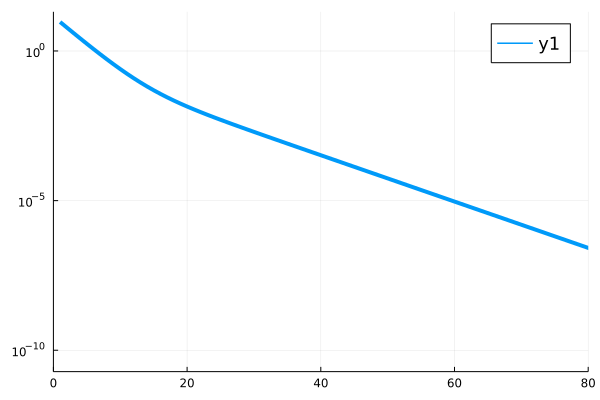

In [43]:
A = [1 1; 1 20]
@show cond(A)
loss(c) = .5 * c' * A * c
grad(c) = A * c

c, chist, lhist = grad_descent(loss, grad, [.9, .9],
    gamma=.09)
plot(lhist, yscale=:log10, xlims=(0, 80))

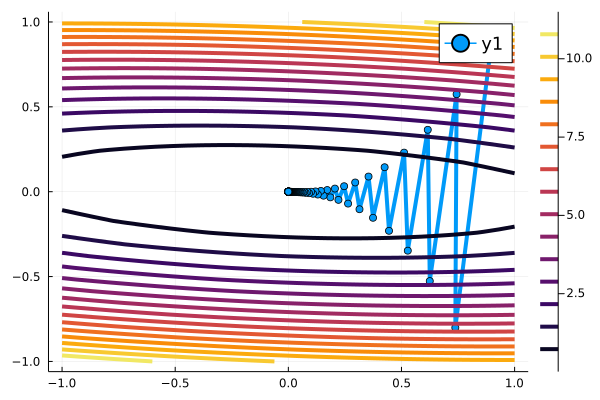

In [44]:
plot(chist[1, :], chist[2, :], marker=:circle)
x = LinRange(-1, 1, 30)
contour!(x, x, (x,y) -> loss([x, y]))

# Chebyshev regression via optimization



In [48]:
x = LinRange(-1, 1, 200)
sigma = 0.5; n = 8
y = runge_noisy(x, sigma)
V = vander_chebyshev(x, n)
function loss(c)
    r = V * c - y
    .5 * r' * r
end
function grad(c)
    r = V * c - y
    V' * r
end
c, _, lhist = grad_descent(loss, grad, ones(n),
    gamma=0.008)
c

8-element Vector{Float64}:
  0.2574425176426252
 -0.07677183142880879
 -0.45869836761594074
 -0.03424918979535217
  0.0015455111399231755
 -0.04040206116680208
 -0.2646122776404021
 -0.022719353732199264

cond(V' * V) = 9.259357328426905


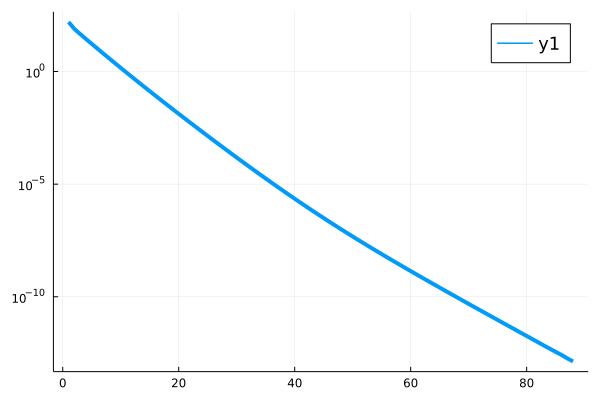

In [49]:
c0 = V \ y
l0 = 0.5 * norm(V * c0 - y)^2
@show cond(V' * V)
plot(lhist .- l0, yscale=:log10)
#plot!(i -> l0, color=:black)

# Why use QR vs gradient-based optimization?

# Nonlinear models

Instead of the linear model
$$ f(x,c) = V(x) c = c_0 + c_1 \underbrace{x}_{T_1(x)} + c_2 T_2(x) + \dotsb $$
let's consider a rational model with only three parameters
$$ f(x,c) = \frac{1}{c_1 + c_2 x + c_3 x^2} = (c_1 + c_2 x + c_3 x^2)^{-1} . $$
We'll use the same loss function
$$ L(c; x,y) = \frac 1 2 \lVert f(x,c) - y \rVert^2 . $$

We will also need the gradient
$$ \nabla_c L(c; x,y) = \big( f(x,c) - y \big)^T \nabla_c f(x,c) $$
where
\begin{align}
\frac{\partial f(x,c)}{\partial c_1} &= -(c_1 + c_2 x + c_3 x^2)^{-2} = - f(x,c)^2 \\
\frac{\partial f(x,c)}{\partial c_2} &= -(c_1 + c_2 x + c_3 x^2)^{-2} x = - f(x,c)^2 x \\
\frac{\partial f(x,c)}{\partial c_3} &= -(c_1 + c_2 x + c_3 x^2)^{-2} x^2 = - f(x,c)^2 x^2 .
\end{align}

# Fitting a rational function

In [51]:
f(x, c) = 1 ./ (c[1] .+ c[2].*x + c[3].*x.^2)
function gradf(x, c)
    f2 = f(x, c).^2
    [-f2 -f2.*x -f2.*x.^2]
end
function loss(c)
    r = f(x, c) - y
    0.5 * r' * r
end
function gradient(c)
    r = f(x, c) - y
    vec(r' * gradf(x, c))
end

gradient (generic function with 1 method)

c = [0.9360587066416243, 0.49240962714220576, 10.23410523331987]


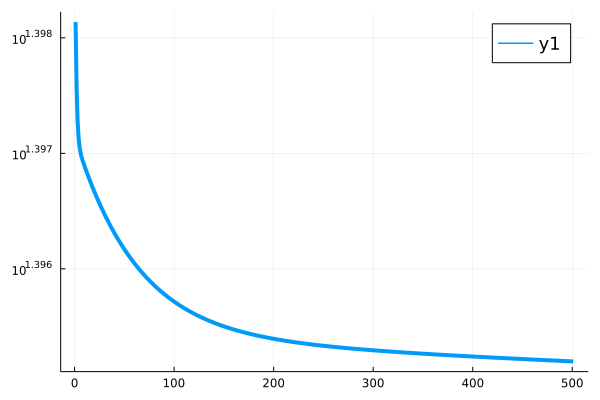

In [87]:
c, _, lhist = grad_descent(loss, gradient, [1., 0, 10.],
    gamma=1e-2)
@show c
plot(lhist, yscale=:log10)

# Compare fits on noisy data

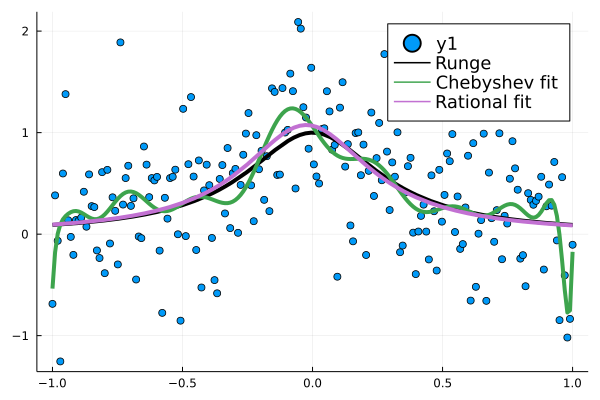

In [88]:
scatter(x, y)
V = vander_chebyshev(x, 20)
plot!(x -> runge(x), color=:black, label="Runge")
plot!(x, V * (V \ y), label="Chebyshev fit")
plot!(x -> f(x, c), label="Rational fit")

# How do we compute those derivatives as the model gets complicated?

$$\lim_{h\to 0} \frac{f(x+h) - f(x)}{h}$$

* How should we choose $h$?

# Taylor series

Classical accuracy analysis assumes that functions are sufficiently smooth, meaning that derivatives exist and Taylor expansions are valid within a neighborhood.  In particular,
$$ f(x+h) = f(x) + f'(x) h + f''(x) \frac{h^2}{2!} + \underbrace{f'''(x) \frac{h^3}{3!} + \dotsb}_{O(h^3)} . $$

The big-$O$ notation is meant in the limit $h\to 0$.  Specifically, a function $g(h) \in O(h^p)$ (sometimes written $g(h) = O(h^p)$) when
there exists a constant $C$ such that
$$ g(h) \le C h^p $$
for all sufficiently *small* $h$.

# Rounding error

We have an additional source of error, *rounding error*, which comes from not being able to compute $f(x)$ or $f(x+h)$ exactly, nor subtract them exactly.  Suppose that we can, however, compute these functions with a relative error on the order of $\epsilon_{\text{machine}}$.  This leads to
$$ \begin{split}
\tilde f(x) &= f(x)(1 + \epsilon_1) \\
\tilde f(x \oplus h) &= \tilde f((x+h)(1 + \epsilon_2)) \\
&= f((x + h)(1 + \epsilon_2))(1 + \epsilon_3) \\
&= [f(x+h) + f'(x+h)(x+h)\epsilon_2 + O(\epsilon_2^2)](1 + \epsilon_3) \\
&= f(x+h)(1 + \epsilon_3) + f'(x+h)x\epsilon_2 + O(\epsilon_{\text{machine}}^2 + \epsilon_{\text{machine}} h)
\end{split}
$$

# Tedious error propagation
$$ \begin{split}
\left\lvert \frac{\tilde f(x+h) \ominus \tilde f(x)}{h} - \frac{f(x+h) - f(x)}{h} \right\rvert &=
  \left\lvert \frac{f(x+h)(1 + \epsilon_3) + f'(x+h)x\epsilon_2 + O(\epsilon_{\text{machine}}^2 + \epsilon_{\text{machine}} h) - f(x)(1 + \epsilon_1) - f(x+h) + f(x)}{h} \right\rvert \\
  &\le \frac{|f(x+h)\epsilon_3| + |f'(x+h)x\epsilon_2| + |f(x)\epsilon_1| + O(\epsilon_{\text{machine}}^2 + \epsilon_{\text{machine}}h)}{h} \\
  &\le \frac{(2 \max_{[x,x+h]} |f| + \max_{[x,x+h]} |f' x| \epsilon_{\text{machine}} + O(\epsilon_{\text{machine}}^2 + \epsilon_{\text{machine}} h)}{h} \\
  &= (2\max|f| + \max|f'x|) \frac{\epsilon_{\text{machine}}}{h} + O(\epsilon_{\text{machine}}) \\
\end{split} $$
where we have assumed that $h \ge \epsilon_{\text{machine}}$.
This error becomes large (relative to $f'$ -- we are concerned with relative error after all)
* $f$ is large compared to $f'$
* $x$ is large
* $h$ is too small

# Automatic step size selection

* Walker and Pernice
* Dennis and Schnabel

In [91]:
diff(f, x; h=1e-8) = (f(x+h) - f(x)) / h

function diff_wp(f, x; eps=1e-8)
    """Diff using Walker and Pernice (1998) choice of step"""
    h = eps * (1 + abs(x))
    (f(x+h) - f(x)) / h
end

x = 1
diff_wp(sin, x) - cos(x)

-2.9698852266335507e-9

# Symbolic differentiation

In [92]:
using Symbolics

@variables x
Dx = Differential(x)

y = sin(x)
Dx(y)

Differential(x)(sin(x))

In [93]:
expand_derivatives(Dx(y))

cos(x)

# Awesome, what about products?

In [96]:
y = x
for _ in 1:3
    y = cos(y^pi) * log(y)
end
expand_derivatives(Dx(y))

(((x^-1)*cos(x^π) - 3.141592653589793(x^2.141592653589793)*log(x)*sin(x^π))*(log(x)^-1)*(cos(x^π)^-1)*cos((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793)) - (3.141592653589793(x^-1)*(log(x)^2.141592653589793)*(cos(x^π)^3.141592653589793) - 9.869604401089358(x^2.141592653589793)*(log(x)^3.141592653589793)*(cos(x^π)^2.141592653589793)*sin(x^π))*sin((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))*log(log(x)*cos(x^π)))*(cos((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))^-1)*(log(log(x)*cos(x^π))^-1)*cos((cos((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))^3.141592653589793)*(log(log(x)*cos(x^π))^3.141592653589793)) - (3.141592653589793((x^-1)*cos(x^π) - 3.141592653589793(x^2.141592653589793)*log(x)*sin(x^π))*(log(x)^-1)*(cos(x^π)^-1)*(cos((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))^3.141592653589793)*(log(log(x)*cos(x^π))^2.141592653589793) - 3.141592653589793(3.141592653589793(x^-1)*(log(x)^2.141592653589793)*(cos(x^π)^3.141592653589793) - 

* The size of these expressions can grow **exponentially**

# Hand-coding derivatives

$$ df = f'(x) dx $$

In [15]:
function f(x)
    y = x
    for _ in 1:2
        a = y^pi
        b = cos(a)
        c = log(y)
        y = b * c
    end
    y
end

f(1.9), diff_wp(f, 1.9)

(-1.5346823414986814, -34.032439961925064)

In [23]:
function df(x, dx)
    y = x
    dy = dx
    for _ in 1:2
        a = y ^ pi
        da = pi * y^(pi - 1) * dy

        
    end
    y, dy
end

df(1.9, 1)

(-1.5346823414986814, -34.03241959914048)

# We can go the other way

We can differentiate a composition $h(g(f(x)))$ as

\begin{align}
  \operatorname{d} h &= h' \operatorname{d} g \\
  \operatorname{d} g &= g' \operatorname{d} f \\
  \operatorname{d} f &= f' \operatorname{d} x.
\end{align}

What we've done above is called "forward mode", and amounts to placing the parentheses in the chain rule like

$$ \operatorname d h = \frac{dh}{dg} \left(\frac{dg}{df} \left(\frac{df}{dx} \operatorname d x \right) \right) .$$

The expression means the same thing if we rearrange the parentheses,

$$ \operatorname d h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname d x .$$

# Automatic differentiation

In [18]:
using Zygote

In [19]:
Zygote.gradient(f, 1.9)

(-34.03241959914049,)

# How does Zygote work?

In [26]:
square(x) = x^2
@code_llvm square(1.5)

;  @ In[26]:1 within `square`
define double @julia_square_11120(double %0) #0 {
top:
; ┌ @ intfuncs.jl:312 within `literal_pow`
; │┌ @ float.jl:405 within `*`
    %1 = fmul double %0, %0
; └└
  ret double %1
}


In [30]:
@code_llvm Zygote.gradient(square, 1.5)

;  @ /home/jed/.julia/packages/Zygote/H6vD3/src/compiler/interface.jl:74 within `gradient`
define [1 x double] @julia_gradient_11254(double %0) #0 {
top:
;  @ /home/jed/.julia/packages/Zygote/H6vD3/src/compiler/interface.jl:76 within `gradient`
; ┌ @ /home/jed/.julia/packages/Zygote/H6vD3/src/compiler/interface.jl:41 within `#56`
; │┌ @ In[26]:1 within `Pullback`
; ││┌ @ /home/jed/.julia/packages/ZygoteRules/AIbCs/src/adjoint.jl:67 within `#1822#back`
; │││┌ @ /home/jed/.julia/packages/Zygote/H6vD3/src/lib/number.jl:6 within `#254`
; ││││┌ @ promotion.jl:380 within `*` @ float.jl:405
       %1 = fmul double %0, 2.000000e+00
; └└└└└
;  @ /home/jed/.julia/packages/Zygote/H6vD3/src/compiler/interface.jl:77 within `gradient`
  %.fca.0.insert = insertvalue [1 x double] zeroinitializer, double %1, 0
  ret [1 x double] %.fca.0.insert
}
